# Machine learning: Boosting de Algoritmos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
from pickle import dump
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score

## Datasets sin feature selection

In [2]:
BASE_PATH = "../data/processed"
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx",
]
TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx",
]
TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")

In [3]:
results = []
models=[]

for index, dataset in enumerate(TRAIN_DATASETS):
    model = XGBClassifier(random_state = 42)
    model.fit(dataset, y_train)
    models.append(model)
    
    y_pred_train = model.predict(dataset)
    y_pred_test = model.predict(TEST_DATASETS[index])

    results.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )

results

[{'train': 1.0, 'test': 0.8831168831168831},
 {'train': 1.0, 'test': 0.8831168831168831}]

Hay overfitting, los accuracies son mejores que las del decision tree pero peores que las del random forest

## Cargando el dataset con feature selection

In [18]:
train_data = pd.read_csv("../data/processed/clean_train_sin_outliers.csv")
test_data = pd.read_csv("../data/processed/clean_test_sin_outliers.csv")

X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

In [19]:
model = XGBClassifier(random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [20]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Train: {accuracy_score(y_train, y_pred_train)}")
print(f"Test: {accuracy_score(y_test, y_pred_test)}")

Train: 1.0
Test: 0.8701298701298701


Es peor valor que el del decision tree optimizado y el random forest

## Hiperparametrización

In [40]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_lambda': [0, 1, 10],
    'reg_alpha': [0, 0.1, 1]
}

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")
model = XGBClassifier(random_state = 42)
grid = GridSearchCV(model, param_grid, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'reg_alpha': [0, 0.1, 1], 'reg_lambda': [0, 1, 10],
                         'subsample': [0.8, 1]},
             scoring='accuracy')

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(TRAIN_DATASETS[1], y_train)

print(f"Mejores hiperparámetros: {grid.best_params_}")

Mejores hiperparámetros: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 1}


In [42]:
model = XGBClassifier(
    max_depth=3,             
    min_child_weight=3,      
    subsample=1,
    colsample_bytree=1,
    n_estimators=50,         
    learning_rate=0.1,      
    reg_alpha=1,
    reg_lambda=0,
    random_state=42,
    eval_metric='logloss',
)

model.fit(TRAIN_DATASETS[1], y_train)

y_pred_train = model.predict(TRAIN_DATASETS[1])
y_pred_test = model.predict(TEST_DATASETS[1])

print(f"Train: {accuracy_score(y_train, y_pred_train)}")
print(f"Test: {accuracy_score(y_test, y_pred_test)}")

Train: 0.9511400651465798
Test: 0.8831168831168831


Peor resultado que el decision-tree y similar al del random forest

In [43]:
dump(model, open("../models/boosting_classifier_sin_outliers_42.sav", "wb"))

## Análisis
El boosting ofrece los mejores resultados sin necesidad de hiperparametrización, después el random forest y por último el decision tree. El mejor modelo se da

Si hay feature selection (k=5) en el dataset, los resultados del random forest y el decision tree (sin necesidad de optimizar) son mejores que los del boosting.

Hay overfitting en todos los casos antes de aplicar hiperparametrización. El EDA podría ser mejorable. Stratify no soluciona este problema. 


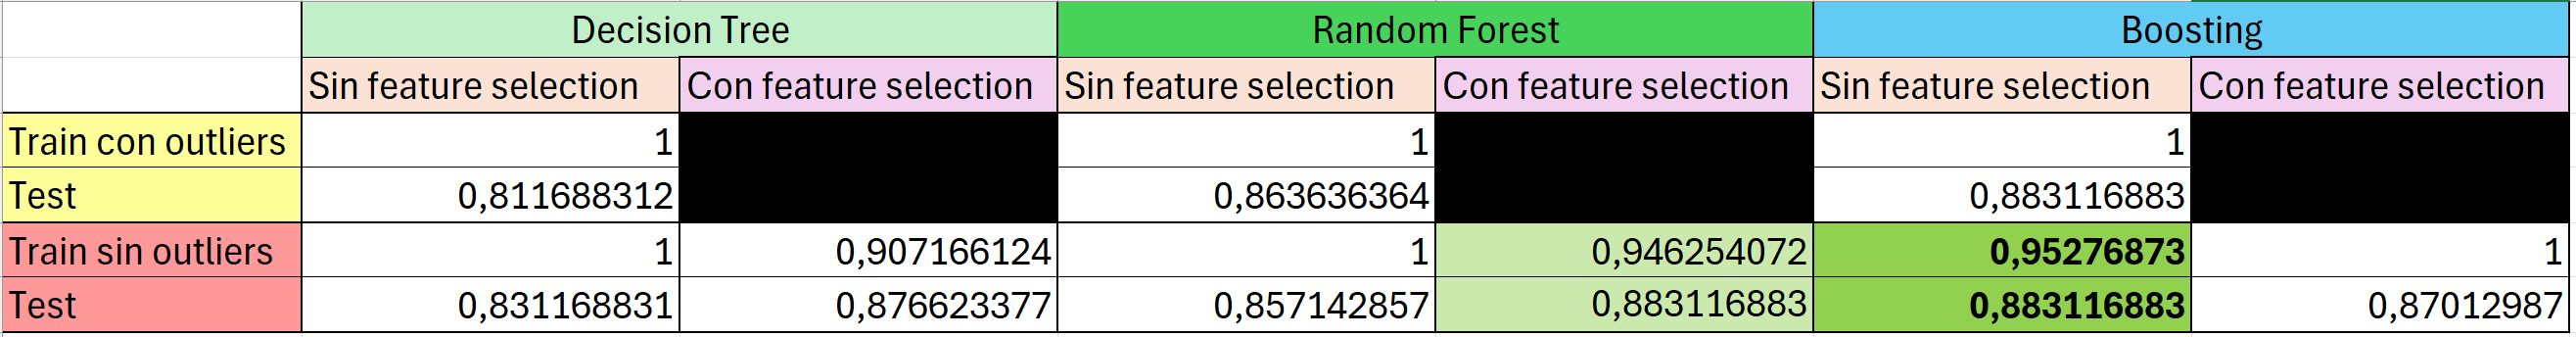